# The House Price Prediction
## Team 4: Vicky Van Der Wagt, Halee Staggs, Bethany Wang

Changes 12/8/22 By: Bethany
* Add price_log column and histogram (removed earlier), we should use it as dependent variable for modeling because the log has normal distribution, but the price distribution is skewed
* Used joint plot to detect outliers by location
* Removed outliers by long, so that the data spread across the whole grid
* Moved location categorical variable construction to section 4 'Feature Engineering'
* Removed/Commented out the code to remove outlier by price, we should not do this, because price is dependent variable
* Added a group of box plots

Changes 12/7/22 by Vicky
* Added quick introduction
* Added check for VIF numbers in 

More thoughts for Discussion

* Make loc_cat two dimentional categories, may use 9 categories if not 15 for modeling
* Standardize/normalize data before modeling
* In the modeling step, do some experiments with more variables and different combinations of variables to achieve the best model
** Candidate variables for modeling: sqft_living, loc_cat, bedrooms, bathrooms, floors, grade

Changes 12/6/22 By: Bethany
* Reorganize and clean up the code before the modeling section
* Modify the way to handle missing data and outliers
* Validate the steps for data cleaning
* Added interpretations

Changes 11/19/22
    
*  Inserted data cleaning setps
* Although earlier we talked about replacing missing values with item that correlates to it the most, after looking at graphs, they do not have clear linear relationships. Therefore, I used the averages for now. Will read more projects to see what else they did. 
* Also added discretization (5 categories for longitude, 3 categories for latitude). Then added a loc_cat column (location category) which has the concatenated values. Clear relationship between loc_cat and price
* For duplicate ids, removed the oldest entry and only kept the most recent one. 
* Removed outliers using quartiles in iqr for sqft_living and sqft_lot since those had the most extreme values. Also concluded the 33 bedroom entry was a mistake, as the square footage was less than 2000(definitely could not fit 33 bedrooms). Therefore, replaced it same method as other bedrooms (with average bedrooms). 
* Holding off on deleting most columns until we decide what is relevant to our models


Changes 11/24/22
1. Remove outliers from price. 

2. Updated "yr_renovated" to Yes/No. Only ~900 with yes. 

3. Converted year built to age. Added column.

4. Normalized outcome variable with square root transformation instead of log. Original data was positively skewed, and then log transformed was negatively skewed so log was not the right method.  

5. Reduced dimensions for lat/long location groups. Added a 3X3 grid to compare. There were 3 long/lat groups that only ontained 1 house. By reducing dimensions, it grouped everything so each area is better represented. When looking at the bar chart, there are 4 distinct price levels. I think we can reduce the location dimensions even further into 3 groups (North, Central, South). The prices differences go North-South more so than East-West. This will help with final model to reduce number of dummy variables.

6. Updated numerical/categorical/ordinal lists of variables. 

7. **Most of our variables are discrete. We cannot compute mean and standard deviation for them. Udated missing values to fill with median. Use PMF for distributions. Median house prices for Washington state listed here: https://ofm.wa.gov/washington-data-research/statewide-data/washington-trends/economic-trends/median-home-price. 2014 = 267,600 and 2015 = 289,100. Maybe we can use this as some sort of cut-off. Add binary variable of above median or below median?? Combine with location?? ** 

8. Ordinal variables can be used in correlations. Added them to the numerical correlation matrix. However, ordinal data is not 100% valid to use in linear regression. Grade is correlated with price, but not rating. 

9. We cannot use price/sqft for a predictor variable. This would mean that we are using a dimension of our dependent variable inside our model, which is invalid. Just stick to continuous measurement of sqft living separate from price. Commented out this section and updated price vs. price/log histogram display.  

10. Tested Spearman rank correlation between ordinal variables (grade and rating). No relationship found. 

11. Added Chi-Square tests for categorical variables to test relationship with price, location, and other categories. Used log-normal price data for test. Turned "price" into categorical with 6 bins to test relationships. 6 bins = 3 SD on each side, so basically 100% of data. The year 2014 contains months from only May-Dec, and 2015 contains months from January to May. This means we cannot use "year" for any meaningful comparison. Together they create a full year of data. Confirmed with x2 test. Also tested month on its own. Month shows a difference in x2 test. Formal test of Vicky's percentage differences.  

12. Normalized sqft_living before modeling with square root transformation.

13. Testing relationship between all predictor variables with x2 conversion. 

14. Final proposed predictor variables: sqft_living - log, location, yr_sold.

15. Ran multinomial linear regression. price_log ~ sqft_log + locations(dummy) + yr_sold + e

16. Added data visualizations.

17. Added conclusion. 

Changes 11/27/22

1. Added 'season' column derived from the month column. (Under Feature Construction and Discretization)

## 1. Introduction

The aim of this project was to build a regression to model house prices in King's County, Washington. The dataset utilized to develop the model contained data for houses that were sold between 2014 and 2015. Therefore, if this model is to predict prices for latter years, that needs to be taken into account and prices need to be normalized. The provided dataset first had to be organized and cleaned accordingly, as there many missing and duplicate values. Some missing variables could be derived from known values, while others were imputed in the manner we felt most reasonable. Exploratory data analysis was then performed, and data was cleaned further and additional features were transformed before fine-tuning the final model. 

## 2. Data Importing and Cleaning

* Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Clean, wrangle, and handle missing data
* Transform data appropriately using techniques such as aggregation, normalization, and feature construction
* Reduce redundant data and perform need-based discretization

In [94]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.api as sm

In [95]:
# To ignore the warning message
warnings.filterwarnings('ignore')

### Import data

In [96]:
dataset = pd.read_csv(r'house_sales.csv')
dataset.shape

(21613, 21)

### Check data characteristics

In [97]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       20479 non-null  float64
 4   bathrooms      20545 non-null  float64
 5   sqft_living    20503 non-null  float64
 6   sqft_lot       20569 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [98]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Check missing data

In [99]:
dataset.isnull().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We detect missigng data in four columns: bedrooms, bathrooms, sqft_living, sqft_lot. Here are the strategies to handle the missing data:
* Fill the missing values in sqft_living: sqft_living = sqft_above +sqft_basement
* Check and remove outliers from sqft_living column: remove 1.5IQR above
* Check distribution of sqft_living and divide it into different groups by size range: 0-999, 1000-1999, ...
* Fill sqft_lot with the mean of the the corresponding size range group
* Fill bedrooms with the median of the the corresponding size range group
* Fill bathrooms with the median of the the corresponding size range group

### Handle Missing Data

#### * Fill the missing values in sqft_living: sqft_living = sqft_above +sqft_basement

In [100]:
sqft_above_col = dataset['sqft_above']
sqft_basement_col = dataset['sqft_basement']
dataset['sqft_living'].fillna(sqft_above_col + sqft_basement_col, inplace = True)

#### * Remove outliers from sqft_living column: use 7000 as the upperlimit accoriding to the scatter plot

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

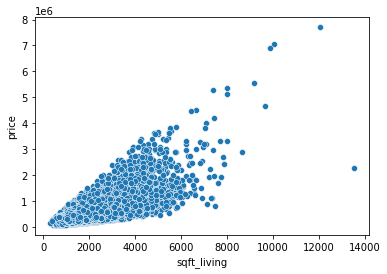

In [101]:
# Use scatter plot to check distribution of sqft_living
sns.scatterplot(data=dataset, x="sqft_living", y="price")

In [102]:
# Calculate IQR
q1 = dataset['sqft_living'].quantile(.25)
q3 = dataset['sqft_living'].quantile(.75)
iqr = q3 - q1
upperlimit = q3 + (1.5 * iqr)
upperlimit_count = len(dataset[dataset.sqft_living > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 4234.5, count = 572


We use 7000 as the upperlimit to define outliers instead of using 1.5IQR

In [103]:
upperlimit1 = 7000
dropped_count = len(dataset[dataset.sqft_living > upperlimit1])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")

dataset = dataset[dataset['sqft_living'] < upperlimit1]

dataset['sqft_sqrt'] = np.sqrt(dataset['sqft_living'])
dataset.shape

28 rows (0.13 percent of data) have been dropped.


(21584, 22)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

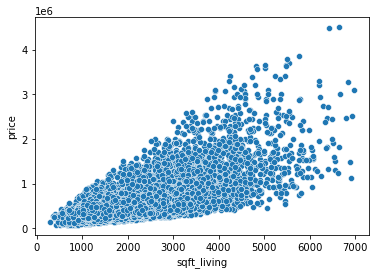

In [104]:
# Recheck sqft_living distribution
sns.scatterplot(data=dataset, x="sqft_living", y="price")

#### * Check sqft_lot distribution

<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

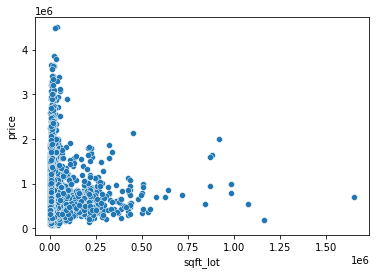

In [105]:
sns.scatterplot(data=dataset, x="sqft_lot", y="price")

#### * Remove outliers from sqft_lot column: use 500000 as the upperlimit accoriding to the scatter plot

In [106]:
#removed outliers with large sqft_lots
q1 = dataset['sqft_lot'].quantile(.25)
q3 = dataset['sqft_lot'].quantile(.75)
iqr = q3 - q1
upperlimit = q3 + (1.5*iqr)
upperlimit_count = len(dataset[dataset.sqft_lot > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 19098.125, count = 2310


In [107]:
# dataset = dataset[dataset['sqft_living']<upperlimit]
upperlimit_set = 500000
upperlimit_set_count = len(dataset[dataset.sqft_lot > upperlimit_set])
print(f"Upper limit_set={upperlimit_set}, count = {upperlimit_set_count}")
dropped_count = len(dataset[dataset.sqft_lot > upperlimit_set])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")

dataset.drop(dataset[dataset.sqft_lot > upperlimit_set].index, inplace=True)


Upper limit_set=500000, count = 20
20 rows (0.093 percent of data) have been dropped.


<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

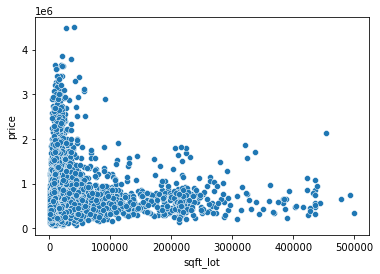

In [108]:
sns.scatterplot(data=dataset, x="sqft_lot", y="price")

#### * Add a column  indicating the sqft_living range: 0 (0-999), 1000 (1000-1999), 2000(2000-2999) ... 6000(6000-6999)

In [109]:
dataset['sqft_living_range'] = (dataset['sqft_living']//1000) * 1000


####  * Impute missing data in bathrooms, bedrooms, sqft_lot with the mean/median by sqft_living_range


In [110]:
# Get unique range list
ranges = dataset['sqft_living_range'].unique()
imputed_dfs = []

for size_range in ranges:
    range_df = dataset[dataset['sqft_living_range'] == size_range]
    range_df['bathrooms'].fillna(range_df['bathrooms'].median(), inplace = True)
    range_df['bedrooms'].fillna(range_df['bedrooms'].median(), inplace = True)
    range_df['sqft_lot'].fillna(range_df['sqft_lot'].mean(), inplace = True)
      
    imputed_dfs.append(range_df)

#Combine all the region subset back into a new dataframe
dataset = pd.concat(imputed_dfs, axis=0)
dataset.isnull().sum()                                                  

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated         0
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
sqft_sqrt            0
sqft_living_range    0
dtype: int64

### Clean up data

#### * Remove outliers from bedrooms  columns

<AxesSubplot:title={'center':'Boxplots'}, xlabel='Bedrooms', ylabel='Counts'>

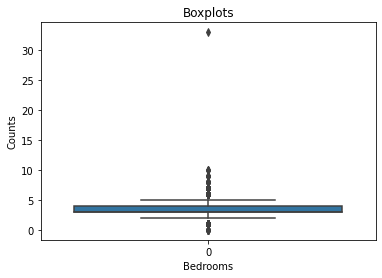

In [111]:
# Use boxplot to check outliers
plt.figure()
plt.title('Boxplots')
plt.xlabel('Bedrooms')
plt.ylabel('Counts')
sns.boxplot(data = dataset['bedrooms'])

From the box plot, any house with more than 6 bedrooms or 0 bedrooms can be counted as an outlier

In [112]:
# Check outliers' count
bedroom_drop_count = len(dataset[(dataset['bedrooms'] > 6) | (dataset['bedrooms'] == 0)])
data_count = len(dataset)
bedroom_drop_count_percent = round(100 * bedroom_drop_count/data_count, 2)

print(f"bedroom_drop_count= {bedroom_drop_count},  Percent={bedroom_drop_count_percent}%")

bedroom_drop_count= 64,  Percent=0.3%


In [113]:
# Drop outliers
dataset = dataset[(dataset['bedrooms'] <= 6) & (dataset['bedrooms'] > 0)]

#### * Remove outliers from bathrooms column

<AxesSubplot:title={'center':'Boxplots'}, xlabel='Bathrooms', ylabel='Counts'>

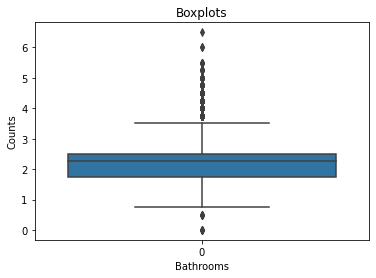

In [114]:
plt.figure()
plt.title('Boxplots')
plt.xlabel('Bathrooms')
plt.ylabel('Counts')
sns.boxplot(data = dataset['bathrooms'])

From the box plot, any house with more than 4 bathrooms or less than 1 bathrooms can be counted as an outlier

In [115]:
# Check outlier counts
bathroom_drop_count = len(dataset[(dataset['bathrooms'] >4) | (dataset['bathrooms'] < 1)])
bathroom_drop_count_percent = round(100 * bathroom_drop_count/data_count, 2)
print(f"bathroom_drop_count= {bathroom_drop_count},  Percent= {bathroom_drop_count_percent}%")


bathroom_drop_count= 294,  Percent= 1.36%


In [116]:
#Drop outliers
dataset = dataset[ (dataset['bathrooms'] <= 4) & (dataset['bathrooms'] >= 1) ]

dataset.shape

(21206, 23)

#### * Remove outliers from price column

In [117]:
#removed outliers in price
# q1 = dataset['price'].quantile(.25)
# q3 = dataset['price'].quantile(.75)
# iqr = q3 - q1

# #tested with 1.5
# upperlimit = q3 + (1.5*iqr)
# lowerlimit = q1 - (1.5*iqr)

# upperlimit_count = len(dataset[dataset.price > upperlimit])
# print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

In [118]:
# dataset = dataset[dataset['price']<upperlimit]

#### * Drop duplicate id

In [119]:
#dropping the earliest entry of each duplicate ID 
dataset.sort_values(by=['id', 'date'], inplace=True)
#keeping the entry with the most recent date
dataset = dataset.drop_duplicates(subset=['id'], keep='last')
dataset.shape


(21031, 23)

* Drop redundant data columns: 

In [120]:
dataset.drop(['sqft_above', 'sqft_basement'], axis=1, inplace = True)

### Feature Transformation

#### * Add columns for year sold, month sold, and season

In [121]:
from datetime import datetime
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y/%m/%d')

In [122]:
dataset['yr_sold'] = pd.DatetimeIndex(dataset['date']).year
dataset['month_sold'] = pd.DatetimeIndex(dataset['date']).month


dataset['month_sold'] = dataset['month_sold'].astype(str)
look_up = {'1': 'Winter', '2': 'Winter', '3': 'Spring', '4': 'Spring', '5': 'Spring', 
           '6': 'Summer', '7': 'Summer', '8': 'Summer', '9': 'Fall', '10': 'Fall', '11': 'Fall', '12': 'Winter'}

dataset['season'] = dataset['month_sold'].apply(lambda x: look_up[x])
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_sqrt,sqft_living_range,yr_sold,month_sold,season
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,98002,47.3262,-122.214,2060,7316,48.989795,2000.0,2015,4,Spring
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,98166,47.4444,-122.351,2590,21891,45.387223,2000.0,2014,5,Spring
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,98166,47.4434,-122.347,2250,20023,38.209946,1000.0,2014,8,Summer
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,98168,47.4783,-122.265,1290,10320,37.815341,1000.0,2015,4,Spring
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.0,1.0,0,0,...,98144,47.5803,-122.294,1480,3504,40.620192,1000.0,2015,3,Spring


#### * Add column to change year renovated to binary variable

In [123]:
#update dataset to Yes/No for renovated
dataset["renovate"] = pd.cut(dataset["yr_renovated"],2,labels = ['0','1'])
dataset["renovate"] = pd.to_numeric(dataset['renovate'])

#### * Add new column house_age = yr_sold - yr_built

In [124]:
t1 = dataset['yr_sold']
t2 = dataset['yr_built']
house_age = t1 - t2
dataset['house_age'] = house_age
dataset[['yr_sold', 'yr_built', 'house_age']].head()

,yr_sold,yr_built,house_age
2497,2015,1991,24
6735,2014,1947,67
8411,2014,1952,62
8809,2015,1930,85
3557,2015,1951,64


## 3. Exploratory Data Analysis and Visualization

* Identify categorical, ordinal, and numerical variables within the data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest

### Classify features

#### * Classify variables as categorical, ordinal, continues and discrete variables within the prepared dataset

In [125]:
# Identify categorical, ordinal, continues and discrete variables within the prepared data
cont_vars = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'house_age']
discrete_vars = ['bedrooms', 'bathrooms', 'floors', 'yr_sold', 'month_sold']
ordinal_vars = ['condition', 'grade']
cat_vars = ['waterfront', 'view', 'zipcode', 'loc_cat', 'season']

### Statistical Analysis

#### * Get statistics on the continous numerical variables, house_age is discrete, but can be used as continuous type

In [126]:
cont_subset = dataset[cont_vars]

In [127]:
# Find the statistics for the numerical variables
round(cont_subset.describe(), 2)

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,house_age
count,21031.00,21031.00,21031.00,21031.00,21031.00,21031.00
mean,527417.53,2047.40,14170.60,1974.19,12401.69,43.33
std,320673.34,841.96,31190.49,665.50,25094.32,29.32
min,78000.00,390.00,520.00,399.00,651.00,-1.00
25%,322500.00,1426.00,5105.50,1481.00,5090.50,18.00
50%,450000.00,1900.00,7800.00,1830.00,7595.00,40.00
75%,635100.00,2520.00,10800.00,2350.00,10008.00,63.00
max,4489000.00,6840.00,499571.00,5790.00,560617.00,115.00


### Correlation Analysis

In [128]:
# Find correlation coefficients between variables
corr_check_cols = cont_vars + discrete_vars + ordinal_vars

corr_check_subset = dataset[corr_check_cols]
round(corr_check_subset.corr(), 2)

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,house_age,bedrooms,bathrooms,floors,yr_sold,condition,grade
price,1.00,0.67,0.08,0.59,0.07,-0.03,0.30,0.48,0.25,0.01,0.04,0.66
sqft_living,0.67,1.00,0.19,0.76,0.17,-0.32,0.60,0.73,0.35,-0.03,-0.06,0.75
sqft_lot,0.08,0.19,1.00,0.17,0.77,-0.06,0.05,0.09,-0.02,-0.01,-0.01,0.12
sqft_living15,0.59,0.76,0.17,1.00,0.18,-0.32,0.41,0.56,0.27,-0.02,-0.09,0.70
sqft_lot15,0.07,0.17,0.77,0.18,1.00,-0.07,0.03,0.08,-0.02,-0.01,-0.00,0.11
house_age,-0.03,-0.32,-0.06,-0.32,-0.07,1.00,-0.17,-0.52,-0.49,0.01,0.36,-0.45
bedrooms,0.30,0.60,0.05,0.41,0.03,-0.17,1.00,0.51,0.17,-0.01,0.02,0.36
bathrooms,0.48,0.73,0.09,0.56,0.08,-0.52,0.51,1.00,0.50,-0.03,-0.13,0.64
floors,0.25,0.35,-0.02,0.27,-0.02,-0.49,0.17,0.50,1.00,-0.02,-0.27,0.45
yr_sold,0.01,-0.03,-0.01,-0.02,-0.01,0.01,-0.01,-0.03,-0.02,1.00,-0.05,-0.03


<AxesSubplot:title={'center':'Heat Map of Correlation Coefficients'}>

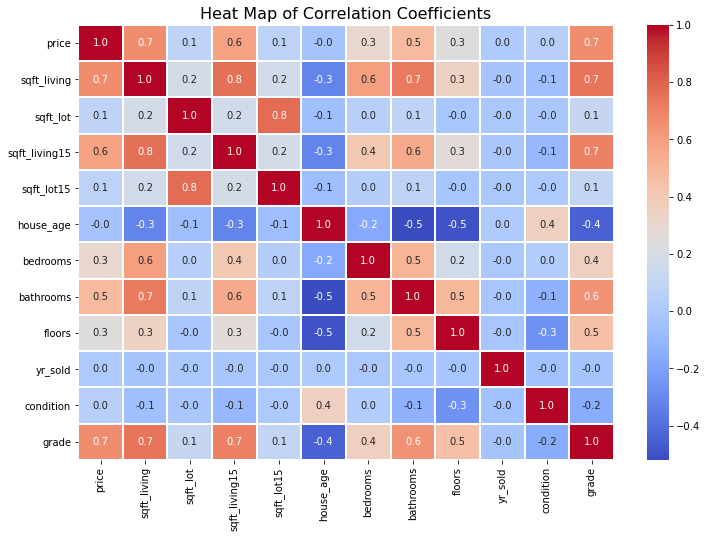

In [129]:
# Heatmap for correlations from original data
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(corr_check_subset.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

From the heatmap, we see:
* Almost no correlation between dependent variable 'price' and independent variables: sqft_lot, house_age, condition, yr_sold, sft_lot15, therefore these variables will not be selected for modeling
* There are strong correlation between sqft_living and sqft_living15, between sqft_lot and sqft_lot15, therefore, we conclude that sqft_living15 and sqft_lot15 are redundant and should not be used in modeling

* There are strong correlation between dependent variable 'price' and independent variables: sqft_living, bathrooms, and grade, therefore these variables will be kept for modeling
* There are weak correlation between dependent variable 'price' and independent variables: bedrooms and floors. These variables will be kept for modeling

### Scatter Plots for Numerical Variables vs. Price

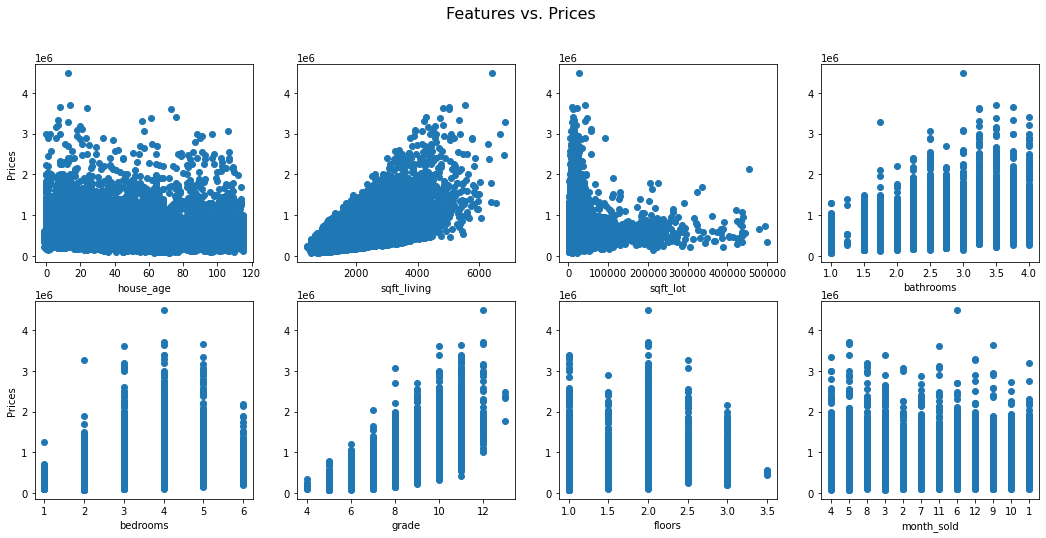

In [130]:
scatter_cols = ['house_age', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade', 'floors', 'month_sold']
pair_cols = ['sqft_living', 'sqft_lot', 'grade', 'condition']

#Create scatter plots
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(18,8))
fig.suptitle("Features vs. Prices",fontsize=16)

#for n in range(len(scatter_cols)):
for n in (0,1,2,3,4,5,6,7):   
    i = 0 if n < 4 else 1  
    j = n % 4;
    axes[i][j].scatter(dataset[scatter_cols[n]], dataset['price'])
    axes[i][j].set_xlabel(scatter_cols[n])
    
axes[0][0].set_ylabel("Prices")
axes[1][0].set_ylabel("Prices")

plt.show()

The scatter plots shows that there is a linear relationship between dependent variable 'price' and independent variables 'sqft_living', 'bathrooms', and, 'grade'. There is no obvious linear relationship between price and the other variables listed above.

### Histogram Distribution for price and sqft_living

In [131]:
# Separate Prices into a new variable
prices = dataset['price']

<AxesSubplot:title={'center':'Distribution of Prices'}, xlabel='price'>

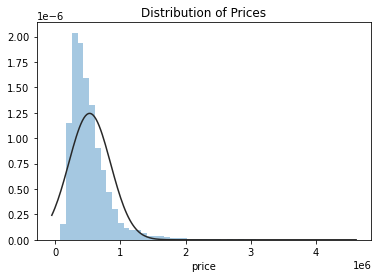

In [132]:
# Display Histogram for Prices
plt.figure(1)
plt.title('Distribution of Prices')
sns.distplot(prices, kde=False, fit=stats.norm)

Because the linear regression model requires that the dependent variable need to have a normal distribution. the distribution of the price is right skewed, therefore, we will try a log transformation on it.

#### Log transformation on price

<AxesSubplot:title={'center':'Distribution of price_log'}, xlabel='price_log'>

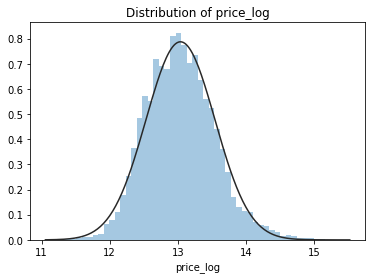

In [133]:
# Add a new column 'price_log'
dataset['price_log'] = np.log(dataset['price'])

# Display Histogram for Sqft_Living
plt.figure(2)
plt.title('Distribution of price_log')
sns.distplot(dataset['price_log'], kde=False, fit=stats.norm)

We see a normal distribution curve for price_log, therefore, price_log will be used for modeling.

### Bar Plots for Categorical and Discrete Variables

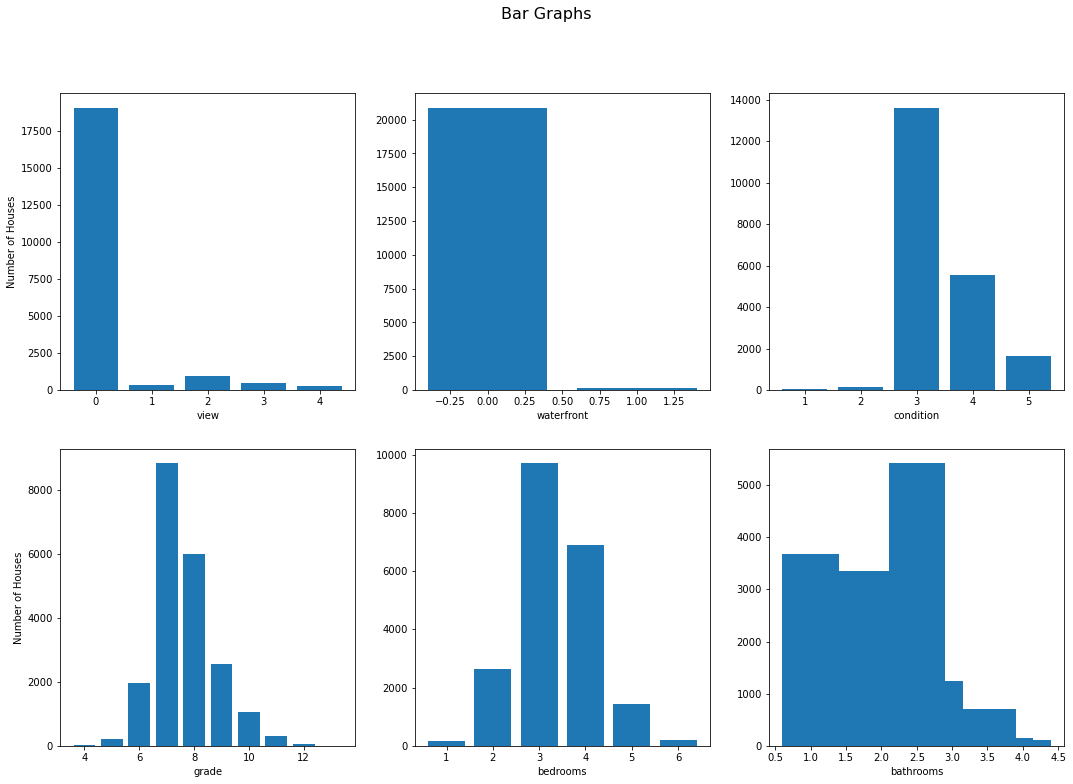

In [134]:
# Define column lists for plotting
bar_cols = ['view', 'waterfront', 'condition', 'grade', 'bedrooms', 'bathrooms']

# Create bar plots
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.suptitle("Bar Graphs",fontsize=16)

for n in (0, 1,2,3,4,5):
    i = 0 if n < 3 else 1  
    j = n % 3;
    values = dataset[bar_cols[n]].value_counts()
    pd.Series.sort_index(values, inplace=True)
    indexes = list(values.index)
    axes[i][j].bar(indexes, values)
    axes[i][j].set_xlabel(bar_cols[n])
    
axes[0][0].set_ylabel("Number of Houses")
axes[1][0].set_ylabel("Number of Houses")

plt.show()

From bar plot for view and water front, we see majority of the housed do not have view or by water front, therefore, these two features will not use considered in modeling

### Box Plot for Bedrooms, Bathrooms, Grade, and Condition

[(0.0, 1500000.0)]

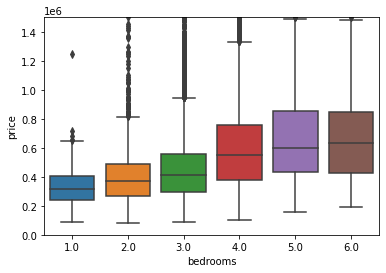

In [135]:
# Display box plot for 'bedrooms'
plot = sns.boxplot(x='bedrooms', y='price', data=dataset)
plot.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

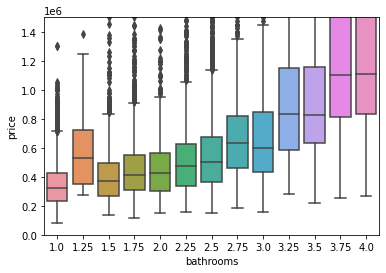

In [136]:
# Display box plot for 'bathrooms'
plot2 = sns.boxplot(x='bathrooms', y='price', data=dataset)
plot2.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

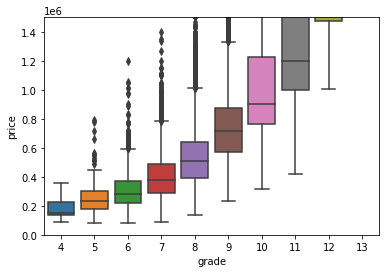

In [137]:
# Display box plot for 'grade'
plot3 = sns.boxplot(x='grade', y='price', data=dataset)
plot3.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

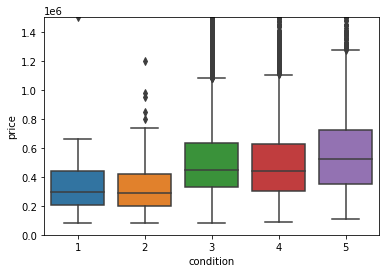

In [138]:
# Display box plot for 'condition'
plot4 = sns.boxplot(x='condition', y='price', data=dataset)
plot4.set(ylim=(0, 1500000))

From the above box plots, we see that bathrooms, bedrooms, and grade affect the price with a certain degree of linear relationship, but condition does not.

### Joint Plot to show Distribution by Latiture and Longitude

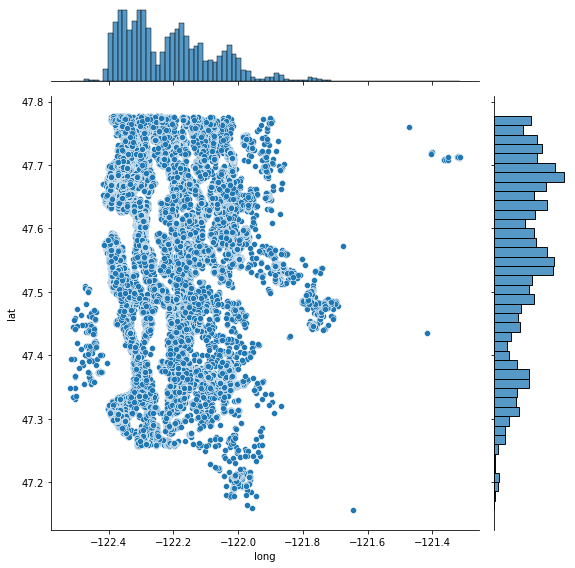

In [139]:
# Joint plot by long and lat
sns.jointplot(dataset['long'], dataset['lat'], size= 8)

### Remove outliers by location : long > -121.7

In [140]:
# Calculate outlier counts
upperlimit_set = -121.7
upperlimit_set_count = len(dataset[dataset.long > upperlimit_set])

dropped_count = len(dataset[dataset.long > upperlimit_set])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")


Upper limit_set=-121.7, count = 21
21 rows (0.1 percent of data) have been dropped.


In [141]:
# Remove outliers for long
dataset.drop(dataset[dataset.long > upperlimit_set].index, inplace=True)

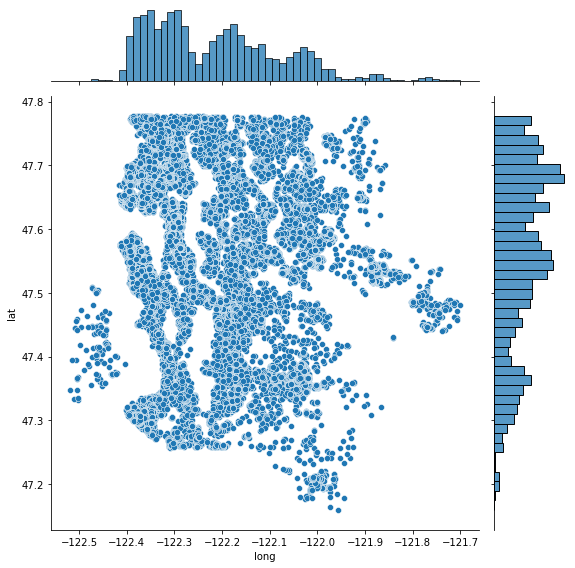

In [142]:
# Recreate joint plot
sns.jointplot(dataset['long'], dataset['lat'], size= 8)

## 4. Feature Engineering

### Feature Construction

#### * Generate Categories for lat, long, and latitude + longitude

[Text(0, 0, 'south-midwest'),
 Text(1, 0, 'central-midwest'),
 Text(2, 0, 'north-midwest'),
 Text(3, 0, 'north-central'),
 Text(4, 0, 'central-central'),
 Text(5, 0, 'central-west'),
 Text(6, 0, 'south-central'),
 Text(7, 0, 'north-west'),
 Text(8, 0, 'north-mideast'),
 Text(9, 0, 'south-west'),
 Text(10, 0, 'south-mideast'),
 Text(11, 0, 'central-mideast'),
 Text(12, 0, 'central-east'),
 Text(13, 0, 'north-east')]

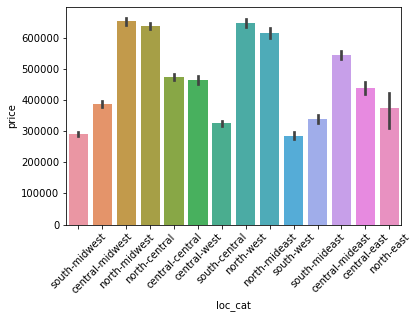

In [143]:
# Add column 'lat_cat' to represent the lattitude in three categories
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

# Add column 'long_cat' to represent the longitude in five categories
dataset['long_cat'] = pd.cut(dataset['long'],5,labels = ['west', 'midwest', 'central', 'mideast', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = dataset['price']

#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

[Text(0, 0, 'south-central'),
 Text(1, 0, 'central-west'),
 Text(2, 0, 'north-west'),
 Text(3, 0, 'central-central'),
 Text(4, 0, 'north-central'),
 Text(5, 0, 'south-west'),
 Text(6, 0, 'north-east'),
 Text(7, 0, 'central-east'),
 Text(8, 0, 'south-east')]

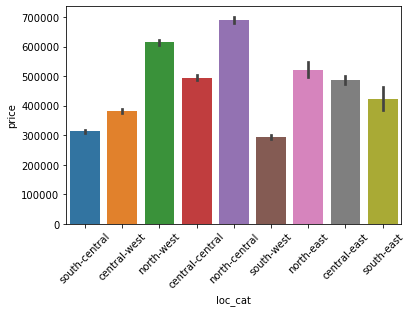

In [144]:
# Add column 'lat_cat' to represent the lattitude in three categories
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

# Add column 'long_cat' to represent the longitude in five categories
dataset['long_cat'] = pd.cut(dataset['long'],3,labels = ['west', 'central', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

### Odinal Correlation & Tests of Association (categorical)

Spearmans Rank Correlation Coefficient

In [145]:
#measure of collinearity for ordinal variables
data_ord = pd.DataFrame(dataset[ordinal_vars])

scc_1, p = spearmanr(data_ord['condition'],data_ord['grade'])
print('scc_1, p = %.3f' % scc_1)


#weak negative correlation between each other

scc_1, p = -0.171


In [146]:
dataset['price_sqrt'] = np.sqrt(dataset['price'])
#cut dataset into 6 bins for price_log
dataset['price_sqrt_cat'] = pd.cut(dataset['price_sqrt'], 6)
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,month_sold,season,renovate,house_age,price_log,lat_cat,long_cat,loc_cat,price_sqrt,price_sqrt_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,4,Spring,0,24,12.611538,south,central,south-central,547.722558,"(277.445, 585.858]"
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,5,Spring,0,67,13.380874,central,west,central-west,804.673847,"(585.858, 892.432]"
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,8,Summer,0,62,12.899220,central,west,central-west,632.455532,"(585.858, 892.432]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,4,Spring,0,85,12.367341,central,west,central-west,484.767986,"(277.445, 585.858]"
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.0,1.0,0,0,...,3,Spring,1,64,12.905450,north,west,north-west,634.428877,"(585.858, 892.432]"


### Price and lattitude location.

In [147]:
#chisq_freq_1_a = pd.crosstab(dataset['price_sqrt_cat'], 
                           #dataset['loc_cat'], 
                           #margins=True, margins_name='Total')
#chisq_freq_1_a

#run test
#stats.chi2_contingency(chisq_freq_1_a)

#not valid


chisq_freq_1_b = pd.crosstab(dataset['price_sqrt_cat'], 
                           dataset['lat_cat'], 
                           margins=True, margins_name='Total')
chisq_freq_1_b

#run test
stats.chi2_contingency(chisq_freq_1_b)

#stat sig, but df and x2 are far apart


(5740.796752333864,
 0.0,
 18,
 array([[7.99509995e+02, 2.29192865e+03, 3.09556135e+03, 6.18700000e+03],
        [1.55456687e+03, 4.45642504e+03, 6.01900809e+03, 1.20300000e+04],
        [3.01867682e+02, 8.65354022e+02, 1.16877830e+03, 2.33600000e+03],
        [4.80713946e+01, 1.37804664e+02, 1.86123941e+02, 3.72000000e+02],
        [9.82103760e+00, 2.81536411e+01, 3.80253213e+01, 7.60000000e+01],
        [1.16301761e+00, 3.33398382e+00, 4.50299857e+00, 9.00000000e+00],
        [2.71500000e+03, 7.78300000e+03, 1.05120000e+04, 2.10100000e+04]]))

### Price and renovation  status.

In [148]:
#create frequency table for price bins and renovation status
chisq_freq_2 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_2
stats.chi2_contingency(chisq_freq_2)

### valid relationship between renovation and price


(379.36031273504784,
 8.819048101810133e-74,
 12,
 array([[5.92903655e+03, 2.57963446e+02, 6.18700000e+03],
        [1.15284160e+04, 5.01584008e+02, 1.20300000e+04],
        [2.23860181e+03, 9.73981913e+01, 2.33600000e+03],
        [3.56489672e+02, 1.55103284e+01, 3.72000000e+02],
        [7.28312232e+01, 3.16877677e+00, 7.60000000e+01],
        [8.62475012e+00, 3.75249881e-01, 9.00000000e+00],
        [2.01340000e+04, 8.76000000e+02, 2.10100000e+04]]))

### Price and year.

In [149]:
chisq_freq_3 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['yr_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_3
stats.chi2_contingency(chisq_freq_3)

#not valid, no difference

(7.454579252000658,
 0.826170881374617,
 12,
 array([[4.17070352e+03, 2.01629648e+03, 6.18700000e+03],
        [8.10951404e+03, 3.92048596e+03, 1.20300000e+04],
        [1.57471528e+03, 7.61284722e+02, 2.33600000e+03],
        [2.50768015e+02, 1.21231985e+02, 3.72000000e+02],
        [5.12321752e+01, 2.47678248e+01, 7.60000000e+01],
        [6.06696811e+00, 2.93303189e+00, 9.00000000e+00],
        [1.41630000e+04, 6.84700000e+03, 2.10100000e+04]]))

### Price and month.

In [150]:
chisq_freq_4 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_4
stats.chi2_contingency(chisq_freq_4)


#valid relationship between price and month

(116.74719274694206,
 0.0006707610454920973,
 72,
 array([[2.78871442e+02, 5.33006663e+02, 4.03435983e+02, 4.21988149e+02,
         3.59853118e+02, 5.44491337e+02, 6.47558924e+02, 6.87902523e+02,
         6.19877915e+02, 6.31068110e+02, 5.53914660e+02, 5.05031176e+02,
         6.18700000e+03],
        [5.42237506e+02, 1.03637792e+03, 7.84440743e+02, 8.20513565e+02,
         6.99698239e+02, 1.05870871e+03, 1.25911328e+03, 1.33755735e+03,
         1.20529034e+03, 1.22704855e+03, 1.07703141e+03, 9.81982389e+02,
         1.20300000e+04],
        [1.05292337e+02, 2.01245121e+02, 1.52323655e+02, 1.59328320e+02,
         1.35868253e+02, 2.05581342e+02, 2.44496145e+02, 2.59728510e+02,
         2.34044741e+02, 2.38269776e+02, 2.09139267e+02, 1.90682532e+02,
         2.33600000e+03],
        [1.67674441e+01, 3.20475964e+01, 2.42570205e+01, 2.53724893e+01,
         2.16365540e+01, 3.27381247e+01, 3.89351737e+01, 4.13608758e+01,
         3.72708234e+01, 3.79436459e+01, 3.33047120e+01, 3.03655402e+

### Price and Season

In [151]:
chisq_freq_4_season = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['season'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_4_season
stats.chi2_contingency(chisq_freq_4_season)

#valid relationship

(65.86512611671746,
 9.080144162510601e-06,
 24,
 array([[1.44147382e+03, 1.87995278e+03, 1.80486069e+03, 1.06071271e+03,
         6.18700000e+03],
        [2.80280105e+03, 3.65537934e+03, 3.50937030e+03, 2.06244931e+03,
         1.20300000e+04],
        [5.44251309e+02, 7.09805997e+02, 6.81453784e+02, 4.00488910e+02,
         2.33600000e+03],
        [8.66701571e+01, 1.13034174e+02, 1.08519181e+02, 6.37764874e+01,
         3.72000000e+02],
        [1.77068063e+01, 2.30930033e+01, 2.21705854e+01, 1.30296050e+01,
         7.60000000e+01],
        [2.09685864e+00, 2.73469776e+00, 2.62546406e+00, 1.54297953e+00,
         9.00000000e+00],
        [4.89500000e+03, 6.38400000e+03, 6.12900000e+03, 3.60200000e+03,
         2.10100000e+04]]))

## Check for Multicolinearity between Predictor Variables

### Change sqft_sqrt to categorical bins. 

In [152]:
#cut square foot living  into 6 bins
dataset['sqft_sqrt_cat'] = pd.cut(dataset['sqft_sqrt'], 6)

#check dataset
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,season,renovate,house_age,price_log,lat_cat,long_cat,loc_cat,price_sqrt,price_sqrt_cat,sqft_sqrt_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,Spring,0,24,12.611538,south,central,south-central,547.722558,"(277.445, 585.858]","(40.734, 51.226]"
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,Spring,0,67,13.380874,central,west,central-west,804.673847,"(585.858, 892.432]","(40.734, 51.226]"
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,Summer,0,62,12.899220,central,west,central-west,632.455532,"(585.858, 892.432]","(30.241, 40.734]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,Spring,0,85,12.367341,central,west,central-west,484.767986,"(277.445, 585.858]","(30.241, 40.734]"
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.0,1.0,0,0,...,Spring,1,64,12.905450,north,west,north-west,634.428877,"(585.858, 892.432]","(30.241, 40.734]"


### Square feet and lattitude location. 

In [153]:
#location and sqft_sqrt

chisq_freq_5 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['lat_cat'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_5
stats.chi2_contingency(chisq_freq_5)

#valid relationship

(225.79884589164018,
 6.546755647196765e-38,
 18,
 array([[1.17464779e+02, 3.36732366e+02, 4.54802856e+02, 9.09000000e+02],
        [8.93068301e+02, 2.56012913e+03, 3.45780257e+03, 6.91100000e+03],
        [1.10977725e+03, 3.18136145e+03, 4.29686130e+03, 8.58800000e+03],
        [4.91827225e+02, 1.40990471e+03, 1.90426806e+03, 3.80600000e+03],
        [9.38167539e+01, 2.68941361e+02, 3.63241885e+02, 7.26000000e+02],
        [9.04569253e+00, 2.59309852e+01, 3.50233222e+01, 7.00000000e+01],
        [2.71500000e+03, 7.78300000e+03, 1.05120000e+04, 2.10100000e+04]]))

### Square feet and month sold

In [154]:
#sqft_sqrt and month

chisq_freq_6 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_6
stats.chi2_contingency(chisq_freq_6)

#not valid

(59.235877684631205,
 0.8593717026213269,
 72,
 array([[4.09720609e+01, 7.83098525e+01, 5.92732032e+01, 6.19989053e+01,
         5.28699667e+01, 7.99971918e+01, 9.51399810e+01, 1.01067301e+02,
         9.10730604e+01, 9.27171347e+01, 8.13816754e+01, 7.41996668e+01,
         9.09000000e+02],
        [3.11504855e+02, 5.95378867e+02, 4.50645883e+02, 4.71369015e+02,
         4.01962970e+02, 6.08207473e+02, 7.23335983e+02, 7.68400571e+02,
         6.92415754e+02, 7.04915421e+02, 6.18733508e+02, 5.64129700e+02,
         6.91100000e+03],
        [3.87093574e+02, 7.39851499e+02, 5.59998096e+02, 5.85749833e+02,
         4.99501951e+02, 7.55793051e+02, 8.98858258e+02, 9.54858068e+02,
         8.60435031e+02, 8.75967825e+02, 7.68873298e+02, 7.01019515e+02,
         8.58800000e+03],
        [1.71550785e+02, 3.27884817e+02, 2.48178010e+02, 2.59590576e+02,
         2.21367539e+02, 3.34949738e+02, 3.98352880e+02, 4.23170681e+02,
         3.81324607e+02, 3.88208377e+02, 3.40746597e+02, 3.10675393e+02,

### Square feet and season. 

In [155]:
#sqft_sqrt and season

chisq_freq_6_season = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['season'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_6_season
#stats.chi2_contingency(chisq_freq_6_season)

#no relationship


season,Fall,Spring,Summer,Winter,Total
sqft_sqrt_cat,,,,,
"(19.685, 30.241]",230,294,237,148,909
"(30.241, 40.734]",1612,2140,1936,1223,6911
"(40.734, 51.226]",1989,2595,2544,1460,8588
"(51.226, 61.719]",889,1127,1157,633,3806
"(61.719, 72.212]",164,204,238,120,726
"(72.212, 82.704]",11,24,17,18,70
Total,4895,6384,6129,3602,21010


### Square feet and renovation.

In [156]:
#sqft_sqrt and renovate

chisq_freq_7 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['renovate'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_7
stats.chi2_contingency(chisq_freq_7)

#not valid relationship

(70.75366305385906,
 2.314410717194294e-10,
 12,
 array([[8.71099762e+02, 3.79002380e+01, 9.09000000e+02],
        [6.62284979e+03, 2.88150214e+02, 6.91100000e+03],
        [8.22992822e+03, 3.58071775e+02, 8.58800000e+03],
        [3.64731099e+03, 1.58689005e+02, 3.80600000e+03],
        [6.95729843e+02, 3.02701571e+01, 7.26000000e+02],
        [6.70813898e+01, 2.91861019e+00, 7.00000000e+01],
        [2.01340000e+04, 8.76000000e+02, 2.10100000e+04]]))

### Location category and month sold.

In [157]:
#create frequency table
#chisq_freq_8_a = pd.crosstab(dataset['loc_cat'], 
                           #dataset['month_sold'].astype('category'), 
                           #margins=True, margins_name='Total')
#chisq_freq_8_a

#run chi square test
#stats.chi2_contingency(chisq_freq_8_a)

#not valid, expected values below 5


chisq_freq_8_b = pd.crosstab(dataset['lat_cat'], 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
chisq_freq_8_b

#run chi square test
stats.chi2_contingency(chisq_freq_8_b)

#VALID relationship


(49.56215921588201,
 0.06562780312579065,
 36,
 array([[  122.37529748,   233.89576392,   177.03712518,   185.17824845,
           157.91194669,   238.9355069 ,   284.16396954,   301.86768206,
           272.01689672,   276.92741552,   243.07068063,   221.61946692,
          2715.        ],
        [  350.8091861 ,   670.50118991,   507.50642551,   530.84431223,
           452.68091385,   684.94845312,   814.60337934,   865.35402189,
           779.78177059,   793.85859115,   696.8026178 ,   635.30913851,
          7783.        ],
        [  473.81551642,   905.60304617,   685.45644931,   716.97743931,
           611.40713946,   925.11603998,  1100.23265112,  1168.77829605,
          1053.2013327 ,  1072.21399334,   941.12670157,   858.07139457,
         10512.        ],
        [  947.        ,  1810.        ,  1370.        ,  1433.        ,
          1222.        ,  1849.        ,  2199.        ,  2336.        ,
          2105.        ,  2143.        ,  1881.        ,  1715.        ,

### Location and season.

In [158]:
chisq_freq_8_season = pd.crosstab(dataset['lat_cat'], 
                           dataset['season'].astype('category'), 
                           margins=True, margins_name='Total')
chisq_freq_8_season

#run chi square test
chisq_freq_8_season
#stats.chi2_contingency(chisq_freq_8_season)


#valid relationship


season,Fall,Spring,Summer,Winter,Total
lat_cat,,,,,
south,633,801,731,550,2715
central,1773,2425,2274,1311,7783
north,2489,3158,3124,1741,10512
Total,4895,6384,6129,3602,21010


### Location category and renovate.

In [159]:
#create frequency table
#chisq_freq_9_a = pd.crosstab(dataset['loc_cat'], 
                           #dataset['renovate'], 
                           #margins=True, margins_name='Total')
#chisq_freq_9_a

#run chi square test
#stats.chi2_contingency(chisq_freq_9_a)

#not valid, expected values below 5


chisq_freq_9_b = pd.crosstab(dataset['lat_cat'], 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
chisq_freq_9_b

#run chi square test
stats.chi2_contingency(chisq_freq_9_b)

#VALID relationship

(38.3962776150615,
 9.397453790566361e-07,
 6,
 array([[ 2601.79961923,   113.20038077,  2715.        ],
        [ 7458.49224179,   324.50775821,  7783.        ],
        [10073.70813898,   438.29186102, 10512.        ],
        [20134.        ,   876.        , 21010.        ]]))

###  Month sold and renovation.

In [160]:
chisq_freq_10 = pd.crosstab(dataset['month_sold'], 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
chisq_freq_10

#run chi square test
#stats.chi2_contingency(chisq_freq_10)

#no relationship

renovate,0,1,Total
month_sold,,,
1,912,35,947
10,1724,86,1810
11,1308,62,1370
12,1377,56,1433
2,1192,30,1222
3,1774,75,1849
4,2121,78,2199
5,2216,120,2336
6,2024,81,2105


### Season and renovation.

In [161]:
chisq_freq_10_season = pd.crosstab(dataset['renovate'], 
                           dataset['season'], 
                           margins=True, margins_name='Total')
chisq_freq_10_season

#run chi square test
chisq_freq_10_season
stats.chi2_contingency(chisq_freq_10_season)


#no relationship

(9.582689170133385,
 0.2955449933585992,
 8,
 array([[ 4690.90575916,  6117.82275107,  5873.45483103,  3451.81665873,
         20134.        ],
        [  204.09424084,   266.17724893,   255.54516897,   150.18334127,
           876.        ],
        [ 4895.        ,  6384.        ,  6129.        ,  3602.        ,
         21010.        ]]))

## 5. Data Modeling and Analytics

* Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
* Train, test, and provide accuracy and evaluation metrics for model results


### The model for data requires a supervised learning method: multinomial linear regression.

* The outcome variable is price (price_sqrt).
* The predictor variables are : sqft_sqrt, season, and renovation status. 

In [162]:
from platform import python_version
python_version()

'3.8.8'

## Creating Dummy Variables

In [163]:
season_dum = pd.get_dummies(dataset['season'], prefix = 'sea')
season_dum

,sea_Fall,sea_Spring,sea_Summer,sea_Winter
2497,0,1,0,0
6735,0,1,0,0
8411,0,0,1,0
8809,0,1,0,0
3557,0,1,0,0
...,...,...,...,...
16737,0,0,1,0
3260,0,1,0,0
7621,0,0,1,0
20979,0,0,1,0


In [164]:
lat_dum = pd.get_dummies(dataset['lat_cat'], prefix = 'lat')
lat_dum

,lat_south,lat_central,lat_north
2497,1,0,0
6735,0,1,0
8411,0,1,0
8809,0,1,0
3557,0,0,1
...,...,...,...
16737,0,1,0
3260,0,1,0
7621,0,1,0
20979,0,1,0


In [165]:
dataset_final = pd.concat([dataset, season_dum, lat_dum], axis = 1)
dataset_final.head(50)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,price_sqrt,price_sqrt_cat,sqft_sqrt_cat,sea_Fall,sea_Spring,sea_Summer,sea_Winter,lat_south,lat_central,lat_north
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.000000,2.0,0,0,...,547.722558,"(277.445, 585.858]","(40.734, 51.226]",0,1,0,0,1,0,0
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.000000,1.0,0,0,...,804.673847,"(585.858, 892.432]","(40.734, 51.226]",0,1,0,0,0,1,0
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.000000,1.0,0,0,...,632.455532,"(585.858, 892.432]","(30.241, 40.734]",0,0,1,0,0,1,0
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.000000,1.5,0,0,...,484.767986,"(277.445, 585.858]","(30.241, 40.734]",0,1,0,0,0,1,0
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.000000,1.0,0,0,...,634.428877,"(585.858, 892.432]","(30.241, 40.734]",0,1,0,0,0,0,1
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.000000,1.0,0,0,...,824.621125,"(585.858, 892.432]","(40.734, 51.226]",0,1,0,0,0,0,1
3200,3800008,2015-02-24,178000.0,5.0,1.50,1990.0,18200.000000,1.0,0,0,...,421.900462,"(277.445, 585.858]","(40.734, 51.226]",0,0,0,1,0,1,0
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.000000,2.0,0,0,...,697.853853,"(585.858, 892.432]","(40.734, 51.226]",0,0,1,0,0,1,0
4333,6200017,2014-11-12,281000.0,3.0,1.00,1340.0,21336.000000,1.5,0,0,...,530.094331,"(277.445, 585.858]","(30.241, 40.734]",1,0,0,0,0,1,0
16715,7200080,2014-11-04,239000.0,4.0,1.75,1980.0,10585.000000,1.5,0,0,...,488.876262,"(277.445, 585.858]","(40.734, 51.226]",1,0,0,0,0,1,0


## Building Model

### Training Data

In [166]:
 from sklearn.linear_model import LinearRegression

X = dataset_final[['sqft_sqrt','lat_north','lat_central','lat_south']]
y = dataset_final[['price_sqrt']]

model = LinearRegression().fit(X, y)
model.score(X,y)

0.6240152147134599

### Checking Variance Inflation Factors (VIFs) of selected variables

In [167]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [168]:
#find design matrix for model using 'price_sqrt' as response variable 
y, X = dmatrices('price_sqrt ~ bedrooms+bathrooms+sqft_living+grade+floors', data=dataset_final, return_type='dataframe')

#calculate the VIF for each explanatory variable (the explarotry values are
#listed after the ~ in line of code above, sepearated by '+'. Can play around)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,82.683424,Intercept
1,1.654683,bedrooms
2,2.635790,bathrooms
3,3.691128,sqft_living
4,2.632266,grade
5,1.429965,floors


In [169]:
model.coef_

array([[  13.55071026,  113.23200376,   -7.37826554, -105.85373822]])

In [170]:
model.intercept_

array([60.14085437])

In [171]:
model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [172]:
model.predict([[50,1,0,0]])

array([[850.90837092]])

In [173]:
from statsmodels.api import OLS
X = sm.add_constant(X)
X_results = OLS(y,X).fit()
X_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqrt   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     5070.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:11:27   Log-Likelihood:            -1.3168e+05
No. Observations:               21010   AIC:                         2.634e+05
Df Residuals:                   21004   BIC:                         2.634e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      54.7210      8.002      6.839      0.000      39.037      70.405
bedrooms      -15.3242      1.333    -11.492      0.000     -17.938     -12.710
bathrooms     -10.6104      2.040     -5.202      0.000     -14.609      -6.612
sqft_living     0.1041      0.002     51.845      0.000       0.100       0.108
grade          68.6827      1.269     54.141      0.000      66.196      71.169
floors        -11.8009      1.951     -6.049      0.000     -15.625      -7.977
==============================================================================
Omnibus:                     2713.667   Durbin-Watson:                   0.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5451.080
Skew:                           0.811   Prob(JB):                         0.00
Kurtosis:                       4.896   Cond. No.                     2.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, \
y_test = train_test_split(X, y, test_size = 0.25, random_state = 222)



In [175]:
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]

# calculate the proportions of each, respectively
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)

print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.7499762018086625
Test Size: 0.25002379819133747


In [176]:
price_model = sm.add_constant(X_train)

In [177]:
price_model_results = OLS(y_train, X_train).fit()
price_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqrt   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     3795.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:11:28   Log-Likelihood:                -98800.
No. Observations:               15757   AIC:                         1.976e+05
Df Residuals:                   15751   BIC:                         1.977e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      58.2608      9.208      6.327      0.000      40.212      76.309
bedrooms      -15.5952      1.541    -10.117      0.000     -18.617     -12.574
bathrooms      -9.1584      2.376     -3.854      0.000     -13.816      -4.500
sqft_living     0.1047      0.002     45.032      0.000       0.100       0.109
grade          67.9542      1.461     46.509      0.000      65.090      70.818
floors        -12.8064      2.257     -5.675      0.000     -17.230      -8.383
==============================================================================
Omnibus:                     2084.602   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4270.971
Skew:                           0.821   Prob(JB):                         0.00
Kurtosis:                       4.952   Cond. No.                     2.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [178]:
price_mod = LinearRegression()
price_mod.fit(X_train, y_train)
y_pred = price_mod.predict(X_test)
y_pred

array([[ 495.66339551],
       [ 573.01471469],
       [ 861.83767463],
       ...,
       [ 621.88901435],
       [ 623.67948382],
       [1037.83829191]])

In [179]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

97.505688405157

In [180]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import absolute

In [181]:
cv = KFold(n_splits=5, random_state=222, shuffle=True)

# use k-fold CV to evaluate model
scores = cross_val_score(price_mod, X_train, y_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# view mean absolute error
ma_scores = mean(absolute(scores))
ma_scores

98.29935911823499

# Regression Visualizations

## 6. Conclusion

## References